In [3]:
import os
working_dir = "/home/gpinon/more_europa/clean_rdc_experiments/projects/P03_evaluate_extractions/"
os.chdir(working_dir)
print(f"Changed working directory to {working_dir}")
import logging
import time
import pandas as pd
import json
from pathlib import Path

from src.p03_evaluate_extractions import costs_estimation

Changed working directory to /home/gpinon/more_europa/clean_rdc_experiments/projects/P03_evaluate_extractions/


In [ ]:
# load evaluation dataset of each field
FIELDS_LIST = [
    "registry_name",
    "geographical_area",
    "medical_condition",
    "outcome_measure",

]
medical_condition_eval_dataset = pd.read_json(
    "../../datasets/005_evaluate_extraction_process_datasets/medical_condition/final_eval_dataset.json"
)
outcome_measure_eval_dataset = pd.read_json(
    "../../datasets/005_evaluate_extraction_process_datasets/outcome_measure/final_eval_dataset.json"
)
geographical_area_eval_dataset = pd.read_json(
    "../../datasets/005_evaluate_extraction_process_datasets/geographical_area/final_eval_dataset.json"
)
registry_name_eval_dataset = pd.read_json(
    "../../datasets/005_evaluate_extraction_process_datasets/registry_name/final_eval_dataset.json"
)

# Extra stats v1

## LARGE MISTRAL

In [96]:
MODEL = "large_mistral"
# define paths
original_metadata_extractions_path=f"data/W02/original/R21_extract_metadata/{MODEL}/metadata_extractions.json"
new_metadata_extractions_path=f"data/W02/new/R21_extract_metadata/{MODEL}/metadata_extractions.json"
# format of original metadata extraction is:
# # load metadata extractions
original_metadata_extractions = pd.read_json(
    original_metadata_extractions_path
)
new_metadata_extractions = pd.read_json(
    new_metadata_extractions_path
)

### Stats on splits on evaluation datasets

In [97]:
# compute the % split of f'correct_{field_name}':
# % of (('Not specified') or ('Not found')) VS different values

def compute_split_correct_field(eval_dataset, field_name):
    """
    Computes the split of the correct field values in the evaluation dataset.
    """
    total = len(eval_dataset)
    not_specified = eval_dataset[field_name].value_counts().get("Not specified", 0)
    not_found = eval_dataset[field_name].value_counts().get("Not found", 0)
    missing = not_specified + not_found
    correct_values = total - missing
    
    return {
        "total": total,
        "missing": missing,
        "correct_values": correct_values
    }

In [98]:
# try on regsitry name, and make a nice print (count + %)
def print_split_correct_field(eval_dataset, field_name):
    split = compute_split_correct_field(eval_dataset, field_name)
    print(f"Field: {field_name}")
    print(f"Total: {split['total']}")
    print(f"Missing (Not specified + Not found): {split['missing']} ({(split['missing']/split['total'])*100:.1f}%)")
    print(f"Correct values: {split['correct_values']} ({(split['correct_values']/split['total'])*100:.1f}%)\n")


In [99]:
# call the functions for all fields
for field in FIELDS_LIST:
    field_name = f"correct_{field}"
    eval_dataset = globals()[f"{field}_eval_dataset"]
    print_split_correct_field(eval_dataset, field_name)
    print("----")

Field: correct_registry_name
Total: 223
Missing (Not specified + Not found): 4 (1.8%)
Correct values: 219 (98.2%)

----
Field: correct_geographical_area
Total: 232
Missing (Not specified + Not found): 43 (18.5%)
Correct values: 189 (81.5%)

----
Field: correct_medical_condition
Total: 260
Missing (Not specified + Not found): 11 (4.2%)
Correct values: 249 (95.8%)

----
Field: correct_outcome_measure
Total: 260
Missing (Not specified + Not found): 7 (2.7%)
Correct values: 253 (97.3%)

----


### Stats on original datasets

In [100]:
FIELDS_LIST_FORMATTED = [
    "Medical condition",
    "Outcome measure",
    "Geographical area",
    "Registry name",
]

In [101]:
# Stats on original datasets. 
# For each field in FIELDS_LIST, compute the split of the <field_name> values in llm_response. 1 category 'missing' for 'Not specified' or 'Not found', and the rest of the values in a single category 'specified'.
def compute_split_llm_response_field(metadata_extractions, field_name):
    """
    Computes the split of the field values in the LLM response.
    """
    total = len(metadata_extractions)
    llm_response_field = metadata_extractions['llm_response'].apply(lambda x: x.get(field_name, "Not specified"))
    not_specified = llm_response_field.value_counts().get("Not specified", 0)
    not_found = llm_response_field.value_counts().get("Not found", 0)
    missing = not_specified + not_found
    specified_values = total - missing
    
    return {
        "total": total,
        "missing": missing,
        "specified_values": specified_values
    }

def print_split_llm_response_field(metadata_extractions, field_name):
    split = compute_split_llm_response_field(metadata_extractions, field_name)
    print(f"Field: {field_name}")
    print(f"Total: {split['total']}")
    print(f"Missing (Not specified + Not found): {split['missing']} ({(split['missing']/split['total'])*100:.1f}%)")
    print(f"Specified values: {split['specified_values']} ({(split['specified_values']/split['total'])*100:.1f}%)\n")

In [102]:
for field_name in FIELDS_LIST_FORMATTED:
    # field_name = f"{field.replace('_', ' ').title()}"
    print_split_llm_response_field(original_metadata_extractions, field_name)
    print("----")

Field: Medical condition
Total: 233
Missing (Not specified + Not found): 8 (3.4%)
Specified values: 225 (96.6%)

----
Field: Outcome measure
Total: 233
Missing (Not specified + Not found): 4 (1.7%)
Specified values: 229 (98.3%)

----
Field: Geographical area
Total: 233
Missing (Not specified + Not found): 102 (43.8%)
Specified values: 131 (56.2%)

----
Field: Registry name
Total: 233
Missing (Not specified + Not found): 66 (28.3%)
Specified values: 167 (71.7%)

----


### Stats on new datasets.

In [103]:
# stats on new datasets

FIELDS_LIST_EXTRA = [
    "Registry name is Official/Unique",
    "Publication type",
]

# For each field in FIELDS_LIST, compute the split of the <field_name> values in llm_response. 1 category 'missing' for 'Not specified' or 'Not found', and the rest of the values in a single category 'specified'.
# THen for each field in FIELDS_LIST_EXTRA, simply compute the counts + split for each category (both fields have 3 classes (there are no 'Not specified' or 'Not found' values)).

def compute_split_extra_fields_llm_response_field(metadata_extractions, field_name):
    """
    Compute the split of the field values in the LLM response for extra fields.
    """
    # THERE IS NO 'Not specified' or 'Not found' values for these fields, so we can simply count the values
    total = len(metadata_extractions)
    llm_response_field = metadata_extractions['llm_response'].apply(lambda x: x.get(field_name, "Missing field"))
    value_counts = llm_response_field.value_counts()

    return {
        "total": total,
        "value_counts": value_counts
    }

def print_split_extra_fields_llm_response_field(metadata_extractions, field_name):
    split = compute_split_extra_fields_llm_response_field(metadata_extractions, field_name)
    print(f"Field: {field_name}")
    print(f"Total: {split['total']}")
    for value, count in split['value_counts'].items():
        print(f"{value}: {count} ({(count/split['total'])*100:.1f}%)")
    print("\n")


In [104]:
# now for each field in FIELDS_LIST, compute and split the values in llm_response
for field in FIELDS_LIST_FORMATTED:
    # field_name = f"{field.replace('_', ' ').title()}"
    print_split_llm_response_field(new_metadata_extractions, field)
    print("----")

# now for each field in FIELDS_LIST_EXTRA, compute and split the values in llm_response
for field in FIELDS_LIST_EXTRA:
    print_split_extra_fields_llm_response_field(new_metadata_extractions, field)
    print("----")


Field: Medical condition
Total: 233
Missing (Not specified + Not found): 1 (0.4%)
Specified values: 232 (99.6%)

----
Field: Outcome measure
Total: 233
Missing (Not specified + Not found): 0 (0.0%)
Specified values: 233 (100.0%)

----
Field: Geographical area
Total: 233
Missing (Not specified + Not found): 28 (12.0%)
Specified values: 205 (88.0%)

----
Field: Registry name
Total: 233
Missing (Not specified + Not found): 1 (0.4%)
Specified values: 232 (99.6%)

----
Field: Registry name is Official/Unique
Total: 233
Missing field: 123 (52.8%)
Yes: 60 (25.8%)
No: 50 (21.5%)


----
Field: Publication type
Total: 233
Exploratory: 117 (50.2%)
Confirmatory: 104 (44.6%)
Survey/Review: 12 (5.2%)


----


### Formatting

In [105]:
import numpy as np

# Create a results dictionary where each key (row) is a field and each value is a dict with stats from each dataset.
results = {}

# Process the standard fields (formatting differences are handled by using the formatted field names)
for formatted_field in FIELDS_LIST_FORMATTED:
    row = {}
    # For evaluation datasets, the column is named "correct_<field>" where field is lowercase and spaces replaced by underscores.
    eval_var_name = f"{formatted_field.lower().replace(' ', '_')}_eval_dataset"
    eval_ds = globals()[eval_var_name]
    eval_col = f"correct_{formatted_field.lower().replace(' ', '_')}"
    split_eval = compute_split_correct_field(eval_ds, eval_col)
    pct_eval = (split_eval['correct_values'] / split_eval['total']) * 100 if split_eval['total'] else np.nan
    row['Eval'] = f"{pct_eval:.1f}%"
    
    # For original metadata extractions, use the llm_response field split for the formatted field.
    split_orig = compute_split_llm_response_field(original_metadata_extractions, formatted_field)
    pct_orig = (split_orig['specified_values'] / split_orig['total']) * 100 if split_orig['total'] else np.nan
    row['Original'] = f"{pct_orig:.1f}%"
    
    # For new metadata extractions, use the same llm_response split.
    split_new = compute_split_llm_response_field(new_metadata_extractions, formatted_field)
    pct_new = (split_new['specified_values'] / split_new['total']) * 100 if split_new['total'] else np.nan
    row['New'] = f"{pct_new:.1f}%"
    
    results[formatted_field] = row

# Process the extra fields (they only exist in new metadata extractions)
for extra_field in FIELDS_LIST_EXTRA:
    row = {}
    # The evaluation and original datasets do not include these extra fields.
    row['Eval'] = np.nan
    row['Original'] = np.nan
    # For new metadata extractions, compute the counts and format them as a summary string.
    split_extra = compute_split_extra_fields_llm_response_field(new_metadata_extractions, extra_field)
    total = split_extra['total']
    counts_summary = "; ".join(
        [f"{cat}: {count} ({(count / total) * 100:.1f}%)" for cat, count in split_extra['value_counts'].items()]
    )
    row['New'] = counts_summary
    results[extra_field] = row

# Create a dataframe from the dictionary. Each row is a field and columns are datasets.
df_results = pd.DataFrame(results).T

df_results

,Eval,Original,New
Medical condition,95.8%,96.6%,99.6%
Outcome measure,97.3%,98.3%,100.0%
Geographical area,81.5%,56.2%,88.0%
Registry name,98.2%,71.7%,99.6%
Registry name is Official/Unique,NaN,NaN,Missing field: 123 (52.8%); Yes: 60 (25.8%); N...
Publication type,NaN,NaN,Exploratory: 117 (50.2%); Confirmatory: 104 (4...


In [106]:
results

{'Medical condition': {'Eval': '95.8%', 'Original': '96.6%', 'New': '99.6%'},
 'Outcome measure': {'Eval': '97.3%', 'Original': '98.3%', 'New': '100.0%'},
 'Geographical area': {'Eval': '81.5%', 'Original': '56.2%', 'New': '88.0%'},
 'Registry name': {'Eval': '98.2%', 'Original': '71.7%', 'New': '99.6%'},
 'Registry name is Official/Unique': {'Eval': nan,
  'Original': nan,
  'New': 'Missing field: 123 (52.8%); Yes: 60 (25.8%); No: 50 (21.5%)'},
 'Publication type': {'Eval': nan,
  'Original': nan,
  'New': 'Exploratory: 117 (50.2%); Confirmatory: 104 (44.6%); Survey/Review: 12 (5.2%)'}}

## Small mistral

In [107]:
# SAME BUT for model 'small_mistral' now
MODEL_SMALL = "small_mistral"
# define paths
original_metadata_extractions_path_small = f"data/W02/original/R21_extract_metadata/{MODEL_SMALL}/metadata_extractions.json"
new_metadata_extractions_path_small = f"data/W02/new/R21_extract_metadata/{MODEL_SMALL}/metadata_extractions.json"
# load metadata extractions
original_metadata_extractions_small = pd.read_json(
    original_metadata_extractions_path_small
)
new_metadata_extractions_small = pd.read_json(
    new_metadata_extractions_path_small
)


In [108]:
# make all computations and prints
# results of original metadata extractions
for field in FIELDS_LIST_FORMATTED:
    print_split_llm_response_field(original_metadata_extractions_small, field)
    print("----")
# results of new metadata extractions
for field in FIELDS_LIST_FORMATTED:
    print_split_llm_response_field(new_metadata_extractions_small, field)
    print("----")
# results of extra fields in new metadata extractions
for field in FIELDS_LIST_EXTRA:
    print_split_extra_fields_llm_response_field(new_metadata_extractions_small, field)
    print("----")


Field: Medical condition
Total: 233
Missing (Not specified + Not found): 10 (4.3%)
Specified values: 223 (95.7%)

----
Field: Outcome measure
Total: 233
Missing (Not specified + Not found): 4 (1.7%)
Specified values: 229 (98.3%)

----
Field: Geographical area
Total: 233
Missing (Not specified + Not found): 88 (37.8%)
Specified values: 145 (62.2%)

----
Field: Registry name
Total: 233
Missing (Not specified + Not found): 51 (21.9%)
Specified values: 182 (78.1%)

----
Field: Medical condition
Total: 198
Missing (Not specified + Not found): 2 (1.0%)
Specified values: 196 (99.0%)

----
Field: Outcome measure
Total: 198
Missing (Not specified + Not found): 0 (0.0%)
Specified values: 198 (100.0%)

----
Field: Geographical area
Total: 198
Missing (Not specified + Not found): 14 (7.1%)
Specified values: 184 (92.9%)

----
Field: Registry name
Total: 198
Missing (Not specified + Not found): 3 (1.5%)
Specified values: 195 (98.5%)

----
Field: Registry name is Official/Unique
Total: 198
Yes: 139 (

In [109]:
# Create a results dictionary for the small model
results_small = {}
# Process the standard fields for the small model
for formatted_field in FIELDS_LIST_FORMATTED:
    row = {}
    # For evaluation datasets, the column is named "correct_<field>" where field is lowercase and spaces replaced by underscores.
    eval_var_name = f"{formatted_field.lower().replace(' ', '_')}_eval_dataset"
    eval_ds = globals()[eval_var_name]
    eval_col = f"correct_{formatted_field.lower().replace(' ', '_')}"
    split_eval = compute_split_correct_field(eval_ds, eval_col)
    pct_eval = (split_eval['correct_values'] / split_eval['total']) * 100 if split_eval['total'] else np.nan
    row['Eval'] = f"{pct_eval:.1f}%"
    
    # For original metadata extractions, use the llm_response field split for the formatted field.
    split_orig = compute_split_llm_response_field(original_metadata_extractions_small, formatted_field)
    pct_orig = (split_orig['specified_values'] / split_orig['total']) * 100 if split_orig['total'] else np.nan
    row['Original'] = f"{pct_orig:.1f}%"
    
    # For new metadata extractions, use the same llm_response split.
    split_new = compute_split_llm_response_field(new_metadata_extractions_small, formatted_field)
    pct_new = (split_new['specified_values'] / split_new['total']) * 100 if split_new['total'] else np.nan
    row['New'] = f"{pct_new:.1f}%"
    
    results_small[formatted_field] = row
# Process the extra fields (they only exist in new metadata extractions)
for extra_field in FIELDS_LIST_EXTRA:
    row = {}
    # The evaluation and original datasets do not include these extra fields.
    row['Eval'] = np.nan
    row['Original'] = np.nan
    # For new metadata extractions, compute the counts and format them as a summary string.
    split_extra = compute_split_extra_fields_llm_response_field(new_metadata_extractions_small, extra_field)
    total = split_extra['total']
    counts_summary = "; ".join(
        [f"{cat}: {count} ({(count / total) * 100:.1f}%)" for cat, count in split_extra['value_counts'].items()]
    )
    row['New'] = counts_summary
    results_small[extra_field] = row

# Create a dataframe from the dictionary for the small model. Each row is a field and columns are datasets.
df_results_small = pd.DataFrame(results_small).T
df_results_small

,Eval,Original,New
Medical condition,95.8%,95.7%,99.0%
Outcome measure,97.3%,98.3%,100.0%
Geographical area,81.5%,62.2%,92.9%
Registry name,98.2%,78.1%,98.5%
Registry name is Official/Unique,NaN,NaN,Yes: 139 (70.2%); No: 59 (29.8%)
Publication type,NaN,NaN,Confirmatory: 92 (46.5%); Exploratory: 92 (46....


In [110]:
results_small

{'Medical condition': {'Eval': '95.8%', 'Original': '95.7%', 'New': '99.0%'},
 'Outcome measure': {'Eval': '97.3%', 'Original': '98.3%', 'New': '100.0%'},
 'Geographical area': {'Eval': '81.5%', 'Original': '62.2%', 'New': '92.9%'},
 'Registry name': {'Eval': '98.2%', 'Original': '78.1%', 'New': '98.5%'},
 'Registry name is Official/Unique': {'Eval': nan,
  'Original': nan,
  'New': 'Yes: 139 (70.2%); No: 59 (29.8%)'},
 'Publication type': {'Eval': nan,
  'Original': nan,
  'New': 'Confirmatory: 92 (46.5%); Exploratory: 92 (46.5%); Survey/Review: 14 (7.1%)'}}

In [111]:
# print results of the small model for new metadata extractions, field "Registry name is Official/Unique"
print(df_results_small.loc["Registry name is Official/Unique", "New"])

Yes: 139 (70.2%); No: 59 (29.8%)


## Gather all 3 model results

In [21]:
# Combine results dictionaries from all 3 models.
combined_results = {}
for field in set(list(results.keys()) + list(results_small.keys()) + list(results_gpt40.keys())):
    combined_results[field] = {}
    if field in results:
        combined_results[field]["large_mistral"] = results[field]
    if field in results_small:
        combined_results[field]["small_mistral"] = results_small[field]
    # if field in results_gpt40:
    #     combined_results[field]["gpt4o_openai"] = results_gpt40[field]

# Create a dataframe from the combined dictionary.
df_all_models = pd.DataFrame(combined_results).T

# # Save the combined results to a JSON file.
# output_json_path = os.path.join(working_dir, "all_models_results.json")
# with open(output_json_path, "w") as f:
#     json.dump(combined_results, f, indent=4)

df_all_models

,large_mistral,small_mistral
Medical condition,"{'Eval': '95.8%', 'Original': '96.6%', 'New': ...","{'Eval': '95.8%', 'Original': '95.7%', 'New': ..."
Registry name,"{'Eval': '98.2%', 'Original': '71.7%', 'New': ...","{'Eval': '98.2%', 'Original': '78.1%', 'New': ..."
Registry name is Official/Unique,"{'Eval': nan, 'Original': nan, 'New': 'Missing...","{'Eval': nan, 'Original': nan, 'New': 'Yes: 13..."
Geographical area,"{'Eval': '81.5%', 'Original': '56.2%', 'New': ...","{'Eval': '81.5%', 'Original': '62.2%', 'New': ..."
Publication type,"{'Eval': nan, 'Original': nan, 'New': 'Explora...","{'Eval': nan, 'Original': nan, 'New': 'Confirm..."
Outcome measure,"{'Eval': '97.3%', 'Original': '98.3%', 'New': ...","{'Eval': '97.3%', 'Original': '98.3%', 'New': ..."


In [93]:
print("Registry name is Official/Unique splits:")

# Large Mistral splits
print("Large Mistral:")
splits_lm = combined_results["Registry name is Official/Unique"]["large_mistral"]["New"]
for item in splits_lm.split("; "):
    print(item)
print()  # blank line for better readability

# Small Mistral splits
print("Small Mistral:")
splits_sm = combined_results["Registry name is Official/Unique"]["small_mistral"]["New"]
for item in splits_sm.split("; "):
    print(item)
print()

# # GPT4o splits
# print("GPT4o:")
# splits_gpt40 = combined_results["Registry name is Official/Unique"]["gpt4o_openai"]["New"]
# for item in splits_gpt40.split("; "):
#     print(item)


Registry name is Official/Unique splits:
Large Mistral:


NameError: name 'combined_results' is not defined

In [94]:
# same for "Publication type" field
print("\nPublication type splits:")
# Large Mistral splits
print("Large Mistral:")
splits_lm_pub = combined_results["Publication type"]["large_mistral"]["New"]
for item in splits_lm_pub.split("; "):
    print(item)
print()  # blank line for better readability
# Small Mistral splits
print("Small Mistral:")
splits_sm_pub = combined_results["Publication type"]["small_mistral"]["New"]
for item in splits_sm_pub.split("; "):
    print(item)
print()  # blank line for better readability
# GPT4o splits
print("GPT4o:")
splits_gpt40_pub = combined_results["Publication type"]["gpt4o_openai"]["New"]
for item in splits_gpt40_pub.split("; "):
    print(item)




Publication type splits:
Large Mistral:


NameError: name 'combined_results' is not defined

In [24]:
# Load computed metrics already saved as JSON files in : "data/W02/<prompt_version>/R23_compute_and_save_perf_metrics/<model>/<field>/perf_metrics.json" to the dictionary
def load_metrics_from_json(model, field):
    """
    Load the performance metrics from a JSON file for a given model and field.
    """
    file_path = f"data/W02/original/R23_compute_and_save_perf_metrics/{model}/{field}/perf_metrics.json"
    if Path(file_path).is_file():
        with open(file_path, "r") as f:
            return json.load(f)
    else:
        logging.warning(f"Metrics file not found: {file_path}")
        return None

# Load metrics for each model and field
metrics = {}
for model in ["large_mistral", "small_mistral", "gpt4o_openai"]:
    metrics[model] = {}
    for field in FIELDS_LIST: # + FIELDS_LIST_EXTRA
        metrics[model][field] = load_metrics_from_json(model, field)
# Create a DataFrame from the metrics dictionary
df_metrics = pd.DataFrame(metrics).T
df_metrics

,medical_condition,outcome_measure,geographical_area,registry_name
large_mistral,"{'field': 'medical_condition', 'model': 'large...","{'field': 'outcome_measure', 'model': 'large_m...","{'field': 'geographical_area', 'model': 'large...","{'field': 'registry_name', 'model': 'large_mis..."
small_mistral,"{'field': 'medical_condition', 'model': 'small...","{'field': 'outcome_measure', 'model': 'small_m...","{'field': 'geographical_area', 'model': 'small...","{'field': 'registry_name', 'model': 'small_mis..."
gpt4o_openai,"{'field': 'medical_condition', 'model': 'gpt4o...","{'field': 'outcome_measure', 'model': 'gpt4o_o...","{'field': 'geographical_area', 'model': 'gpt4o...","{'field': 'registry_name', 'model': 'gpt4o_ope..."


## Individual prompts 

## Mistral medium

In [25]:
MODEL = "medium_mistral"

In [26]:
# individual prompts extractions loading
FIELD_LIST = [
    "medical_condition",
    "outcome_measure",
    "geographical_area",
    "registry_name",
]

In [27]:
# define paths
# "data/W03/R31_extract_metadata_one_by_one/{field}/{model}/{field}_metadata_extractions.json"
individual_extractions = {}
for field in FIELD_LIST:
    individual_extractions[field] = pd.read_json(
        f"data/W03/R31_extract_metadata_one_by_one/{field}/{MODEL}/"
        f"{field}_metadata_extractions.json"
    )
# load the perf metrics for each field and model
# data/W03/R33_compute_and_save_perf_metrics_one_by_one/{field}/{model}/perf_metrics.json
perf_metrics = {}
for field in FIELD_LIST:
    perf_metrics[field] = {}
    perf_metrics[field][MODEL] = json.load(
        open(f"data/W03/R33_compute_and_save_perf_metrics_one_by_one/{field}/{MODEL}/perf_metrics.json")
    )

In [28]:
# format of individual_extractions is
# [
#     {
#         "object_id": "003188f2-47f3-5bf5-bb9d-267c4569597a",
#         "title": "<TITLE>",
#         "abstract": "<ABSTRACT>",
#         "llm_response": {
#             "key 1": "<VALUE 1>",
#             "...
#             "<field>": "<VALUE>",
#             "custom_id": "<CUSTOM ID>",
#         }
#     },

# format of  perf_metrics is:
# {
#     "field": "<field>",
#     "model": "<model>",
#     "summary": {
#         "total_samples": 229,
#         "accuracy": 0.6375545851528385,
#         "correct_extractions": 146,
#         "incorrect_extractions": 83
#     },
#     "reason_breakdown": {
#         "correct_extractions": {
#             "total": 146,
#             "percentage": 0.6375545851528385,
#             "reasons": {
#                 "llm_same": 33,
#                 "model_agreement": 113
#             }
#         },
#         "incorrect_extractions": {
#             "total": 83,
#             "percentage": 0.36244541484716153,
#             "reasons": {
#                 "llm_different": 24,
#                 "one_model_unspecified": 59
#             }
#         }
#     }
# }

In [29]:
## Create a dictionary with all perf metrics of the model: total samples + accuracy
def create_perf_metrics_dict(perf_metrics, model):
    """
    Create a dictionary with the performance metrics of the model.
    """
    perf_dict = {}
    for field, metrics in perf_metrics.items():
        if model in metrics:
            summary = metrics[model]['summary']
            perf_dict[field] = {
                # 'total_samples': summary['total_samples'],
                'accuracy': summary['accuracy'],
                # 'correct_extractions': summary['correct_extractions'],
                # 'incorrect_extractions': summary['incorrect_extractions']
            }
    return perf_dict

# Create the performance metrics dictionary for the model
perf_metrics_dict_medium = create_perf_metrics_dict(perf_metrics, MODEL)

In [30]:
# compute stats on extra fields: 'Publication type' in 'Outcome measure' and 'Registry name is Official/Unique' in 'Registry name'
# simply compute the values counts (total samples and the percentage of each value)
def compute_extra_fields_stats(extractions, field_name):
    """
    Computes the stats for extra fields in the metadata extractions.
    """
    total = len(extractions)
    llm_response_field = extractions['llm_response'].apply(lambda x: x.get(field_name, "Missing field"))
    value_counts = llm_response_field.value_counts()
    
    return {
        "total": total,
        "value_counts": value_counts
    }

def print_extra_fields_stats(extractions, field_name):
    stats = compute_extra_fields_stats(extractions, field_name)
    print(f"Field: {field_name}")
    print(f"Total: {stats['total']}")
    for value, count in stats['value_counts'].items():
        print(f"{value}: {count} ({(count/stats['total'])*100:.1f}%)")
    print("\n")

In [31]:
# start with the 'Publication type' field in 'Outcome measure'
print("Publication type stats in Outcome measure extractions:")
print_extra_fields_stats(individual_extractions["outcome_measure"], "Publication type")
# now for the 'Registry name is Official/Unique' field in 'Registry name'
print("Registry name is Official/Unique stats in Registry name extractions:")
print_extra_fields_stats(individual_extractions["registry_name"], "Registry name is Official/Unique")

Publication type stats in Outcome measure extractions:
Field: Publication type
Total: 233
Exploratory: 178 (76.4%)
Confirmatory: 43 (18.5%)
Survey/Review: 12 (5.2%)


Registry name is Official/Unique stats in Registry name extractions:
Field: Registry name is Official/Unique
Total: 233
Yes: 157 (67.4%)
No: 69 (29.6%)
Missing field: 7 (3.0%)




## MISTRAL SMALL

In [32]:
# DO all the same for the small model
MODEL_SMALL = "small_mistral"
# individual prompts extractions loading
individual_extractions_small = {}
for field in FIELD_LIST:
    individual_extractions_small[field] = pd.read_json(
        f"data/W03/R31_extract_metadata_one_by_one/{field}/{MODEL_SMALL}/"
        f"{field}_metadata_extractions.json"
    )
# load the perf metrics for each field and model
perf_metrics_small = {}
for field in FIELD_LIST:
    perf_metrics_small[field] = {}
    perf_metrics_small[field][MODEL_SMALL] = json.load(
        open(f"data/W03/R33_compute_and_save_perf_metrics_one_by_one/{field}/{MODEL_SMALL}/perf_metrics.json")
    )
# compute stats on extra fields: 'Publication type' in 'Outcome measure' and 'Registry name is Official/Unique' in 'Registry name'
# simply compute the values counts (total samples and the percentage of each value)
# start with the 'Publication type' field in 'Outcome measure'
print("Publication type stats in Outcome measure extractions (small model):")
print_extra_fields_stats(individual_extractions_small["outcome_measure"], "Publication type")
# now for the 'Registry name is Official/Unique' field in 'Registry name'
print("Registry name is Official/Unique stats in Registry name extractions (small model):")
print_extra_fields_stats(individual_extractions_small["registry_name"], "Registry name is Official/Unique")

Publication type stats in Outcome measure extractions (small model):
Field: Publication type
Total: 233
Exploratory: 127 (54.5%)
Confirmatory: 95 (40.8%)
Survey/Review: 11 (4.7%)


Registry name is Official/Unique stats in Registry name extractions (small model):
Field: Registry name is Official/Unique
Total: 233
Yes: 160 (68.7%)
No: 73 (31.3%)




In [33]:
# compute the performance metrics dictionary for the small model
perf_metrics_dict_small = create_perf_metrics_dict(perf_metrics_small, MODEL_SMALL)

## large mistral

In [52]:
# individual prompts extractions loading
FIELD_LIST = [
    # "medical_condition",
    "outcome_measure",
    # "geographical_area",
    "registry_name",
]

In [54]:
# DO all the same for the large mistral model
MODEL_LARGE = "large_mistral"
# individual prompts extractions loading
individual_extractions_large = {}
for field in FIELD_LIST:
    individual_extractions_large[field] = pd.read_json(
        f"data/W03/R31_extract_metadata_one_by_one/{field}/{MODEL_LARGE}/"
        f"{field}_metadata_extractions.json"
    )
# # load the perf metrics for each field and model
# perf_metrics_large = {}
# for field in FIELD_LIST:
#     perf_metrics_large[field] = {}
#     perf_metrics_large[field][MODEL_LARGE] = json.load(
#         open(f"data/W03/R33_compute_and_save_perf_metrics_one_by_one/{field}/{MODEL_LARGE}/perf_metrics.json")
#     )
# compute stats on extra fields: 'Publication type' in 'Outcome measure' and 'Registry name is Official/Unique' in 'Registry name'
# simply compute the values counts (total samples and the percentage of each value)
# start with the 'Publication type' field in 'Outcome measure'
print("Publication type stats in Outcome measure extractions (large model):")
print_extra_fields_stats(individual_extractions_large["outcome_measure"], "Publication type")
# now for the 'Registry name is Official/Unique' field in 'Registry name'
print("Registry name is Official/Unique stats in Registry name extractions (large model):")
print_extra_fields_stats(individual_extractions_large["registry_name"], "Registry name is Official/Unique")


Publication type stats in Outcome measure extractions (large model):
Field: Publication type
Total: 231
Exploratory: 140 (60.6%)
Confirmatory: 79 (34.2%)
Survey/Review: 12 (5.2%)


Registry name is Official/Unique stats in Registry name extractions (large model):
Field: Registry name is Official/Unique
Total: 232
Yes: 153 (65.9%)
No: 79 (34.1%)




In [ ]:
# compute the performance metrics dictionary for the large model
perf_metrics_dict_large = create_perf_metrics_dict(perf_metrics, MODEL_LARGE)

## GPT4_1_model

In [55]:
# do the same for the gpt4_1_openai model
MODEL_GPT41 = "gpt4_1_openai"
# individual prompts extractions loading
individual_extractions_gpt41 = {}
for field in FIELD_LIST:
    individual_extractions_gpt41[field] = pd.read_json(
        f"data/W03/R31_extract_metadata_one_by_one/{field}/{MODEL_GPT41}/"
        f"{field}_metadata_extractions.json"
    )
# # load the perf metrics for each field and model
# perf_metrics_gpt41 = {}
# for field in FIELD_LIST:
#     perf_metrics_gpt41[field] = {}
#     perf_metrics_gpt41[field][MODEL_GPT41] = json.load(
#         open(f"data/W03/R33_compute_and_save_perf_metrics_one_by_one/{field}/{MODEL_GPT41}/perf_metrics.json")
#     )
# compute stats on extra fields: 'Publication type' in 'Outcome measure' and 'Registry name is Official/Unique' in 'Registry name'
# simply compute the values counts (total samples and the percentage of each value)
# start with the 'Publication type' field in 'Outcome measure'
print("Publication type stats in Outcome measure extractions (gpt4_1_openai model):")
print_extra_fields_stats(individual_extractions_gpt41["outcome_measure"], "Publication type")
# now for the 'Registry name is Official/Unique' field in 'Registry name'
print("Registry name is Official/Unique stats in Registry name extractions (gpt4_1_openai model):")
print_extra_fields_stats(individual_extractions_gpt41["registry_name"], "Registry name is Official/Unique")


Publication type stats in Outcome measure extractions (gpt4_1_openai model):
Field: Publication type
Total: 233
Exploratory: 120 (51.5%)
Confirmatory: 105 (45.1%)
Survey/Review: 8 (3.4%)


Registry name is Official/Unique stats in Registry name extractions (gpt4_1_openai model):
Field: Registry name is Official/Unique
Total: 233
Yes: 156 (67.0%)
No: 77 (33.0%)




In [ ]:
# compute the performance metrics dictionary for the gpt4_1_openai model
perf_metrics_dict_gpt41 = create_perf_metrics_dict(perf_metrics, MODEL_GPT41)

## Gather all results

In [67]:
## gather all results in a single dictionary, to later show a dataframe with 1 row per field and 1 column per model, values are the accuracy percentages with 1 decimal.
dict_all_results= {}
# Add results for the medium model
for field in perf_metrics_dict_medium:
    dict_all_results[field] = {
        "medium_mistral": f"{perf_metrics_dict_medium[field]['accuracy'] * 100:.1f}%",
    }
# Add results for the small model
for field in perf_metrics_dict_small:
    if field not in dict_all_results:
        dict_all_results[field] = {}
    dict_all_results[field]["small_mistral"] = f"{perf_metrics_dict_small[field]['accuracy'] * 100:.1f}%"


# Create a dataframe from the dictionary. Each row is a field and columns are models, and cell values are the accuracy percentages.
df_results_all_models = pd.DataFrame(dict_all_results).T

In [68]:
# show the dataframe
df_results_all_models

,medium_mistral,small_mistral
medical_condition,93.7%,92.4%
outcome_measure,93.3%,90.1%
geographical_area,63.8%,64.0%
registry_name,91.5%,90.1%


# Comparing results

In this section, we'll compare metrics across different combinations of prompt versions and models. We'll analyze the performance of:

In [26]:
# Create a function to load performance metrics from JSON files
def load_performance_metrics(prompt_version, model, field):
    """Load performance metrics from JSON files based on prompt version and model.
    
    Args:
        prompt_version: 'original', 'new', or 'individual'
        model: 'small_mistral', 'medium_mistral', or 'large_mistral'
        field: field name (e.g., 'outcome_measure')
        
    Returns:
        Dictionary with accuracy and total_samples
    """
    if prompt_version == 'individual':
        # Individual prompt format
        file_path = f"data/W03/R33_compute_and_save_perf_metrics_one_by_one/{field}/{model}/perf_metrics.json"
    else:
        # Original or new prompt format
        file_path = f"data/W02/{prompt_version}/R23_compute_and_save_perf_metrics/{model}/{field}/perf_metrics.json"
    
    try:
        with open(file_path, "r") as f:
            metrics = json.load(f)
            return {
                "accuracy": metrics["summary"]["accuracy"],
                "total_samples": metrics["summary"]["total_samples"]
            }
    except (FileNotFoundError, KeyError) as e:
        print(f"Error loading metrics from {file_path}: {e}")
        return {"accuracy": None, "total_samples": None}

# Define the combinations we want to analyze
combinations = [
    {"prompt_version": "original", "model": "small_mistral"},
    {"prompt_version": "original", "model": "large_mistral"},
    {"prompt_version": "new", "model": "small_mistral"},
    {"prompt_version": "new", "model": "large_mistral"},
    {"prompt_version": "individual", "model": "small_mistral"},
    {"prompt_version": "individual", "model": "medium_mistral"}
]

# Create a dictionary to store all metrics
comparison_results = {}

# Load metrics for each combination and field
for combo in combinations:
    prompt_version = combo["prompt_version"]
    model = combo["model"]
    key = f"{prompt_version}_{model}"
    comparison_results[key] = {
        "prompt_version": prompt_version,
        "model": model
    }
    
    # Load metrics for each field
    for field in FIELDS_LIST:
        metrics = load_performance_metrics(prompt_version, model, field)
        comparison_results[key][field] = metrics

In [46]:
# Convert the results to a pandas DataFrame for easier analysis
results_df = pd.DataFrame(columns=["prompt_version", "model"] + FIELDS_LIST)

# Populate the DataFrame from comparison_results
for key, data in comparison_results.items():
    row = {
        "prompt_version": data["prompt_version"],
        "model": data["model"]
    }
    
    # Add accuracy for each field
    for field in FIELDS_LIST:
        if field in data and data[field]["accuracy"] is not None:
            row[field] = f"{data[field]['accuracy']*100:.1f}%"
        else:
            row[field] = "N/A"
    
    results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

# Add extra row for 'no_registry_related_filter' and 'small_mistral'
# where each field value is 73% * accuracy of the combination (original + small_mistral)
original_small = comparison_results.get("original_small_mistral", {})
new_row = {
    "prompt_version": "no_registry_related_filter",
    "model": "small_mistral"
}
for field in FIELDS_LIST:
    if field in original_small and original_small[field]["accuracy"] is not None:
        # Multiply the original accuracy by 0.73
        adjusted_accuracy = 0.73 * original_small[field]["accuracy"]
        new_row[field] = f"{adjusted_accuracy*100:.1f}%"
    else:
        new_row[field] = "N/A"

results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

# Display the results
results_df

,prompt_version,model,registry_name,geographical_area,medical_condition,outcome_measure
0,original,small_mistral,77.1%,81.7%,92.4%,84.8%
1,original,large_mistral,72.6%,74.2%,92.8%,91.0%
2,new,small_mistral,87.9%,88.9%,91.9%,86.1%
3,new,large_mistral,90.0%,91.5%,91.8%,89.1%
4,individual,small_mistral,90.1%,98.4%,92.4%,90.1%
5,individual,medium_mistral,91.5%,98.7%,93.7%,93.3%
6,no_registry_related_filter,small_mistral,56.3%,59.6%,67.4%,61.9%


Let's visualize the accuracy across different combinations:

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# define the color code
color_map = {
    "original_small_mistral": "#ADD8E6",  # light blue
    "original_large_mistral": "#00008B",  # dark blue
    "new_small_mistral": "#FFDAB9",       # light orange
    "new_large_mistral": "#FF8C00",       # dark orange
    "individual_small_mistral": "#90EE90",# light green
    "individual_medium_mistral": "#006400", # dark green
    "no_registry_related_filter_small_mistral": "#D3D3D3"  # light grey
}

In [48]:
def compare_fields_between_combinations(df, combo1, combo2, color_map=color_map):
    """
    Compare fields between two combinations of prompt version and model, using the color code.

    Args:
        df: DataFrame containing the results.
        combo1: First combination (e.g., "original_small_mistral").
        combo2: Second combination (e.g., "new_large_mistral").
        color_map: Dictionary mapping combination keys to colors.
    """
    def format_combo_label(combo):
        parts = combo.split("_", 1)
        if len(parts) == 2:
            return f"{parts[0]} prompt + {parts[1]}"
        return combo

    # Extract the rows for the two combinations
    row1 = df[df["prompt_version"] + "_" + df["model"] == combo1].iloc[0]
    row2 = df[df["prompt_version"] + "_" + df["model"] == combo2].iloc[0]
    
    # Create a bar chart comparing the fields
    fields = FIELDS_LIST
    values1 = [float(row1[field].strip('%')) for field in fields]
    values2 = [float(row2[field].strip('%')) for field in fields]
    
    x = np.arange(len(fields))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 7.4))
    
    bars1 = ax.bar(x - width/2, values1, width, label=format_combo_label(combo1), 
                   color=color_map.get(combo1))
    bars2 = ax.bar(x + width/2, values2, width, label=format_combo_label(combo2),
                   color=color_map.get(combo2))
    
    # Annotate each bar with its accuracy value (0 decimals)
    for bar in bars1:
        h = bar.get_height()
        ax.annotate(f'{h:.0f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')
    for bar in bars2:
        h = bar.get_height()
        ax.annotate(f'{h:.0f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(f'Comparison of Fields between {combo1} and {combo2}')
    ax.set_xticks(x)
    ax.set_xticklabels(fields)
    ax.set_ylim(0, 110)
    ax.set_yticks(np.arange(0, 106, 10))
    ax.axhline(y=100, color='black', linestyle='--', linewidth=1)
    ax.legend(loc='upper right')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
# define a function to compare 3 combinations of prompt version and model with a bar chart
def compare_fields_between_three_combinations(df, combo1, combo2, combo3):
    """
    Compare fields between three combinations of prompt version and model.
    
    Args:
        df: DataFrame containing the results.
        combo1: First combination (e.g., "original_small_mistral").
        combo2: Second combination (e.g., "new_large_mistral").
        combo3: Third combination (e.g., "individual_medium_mistral").
    """
    def format_combo_label(combo):
        parts = combo.split("_", 1)
        if len(parts) == 2:
            return f"{parts[0]} prompt + {parts[1]}"
        return combo

    # Extract the rows for the three combinations
    row1 = df[df["prompt_version"] + "_" + df["model"] == combo1].iloc[0]
    row2 = df[df["prompt_version"] + "_" + df["model"] == combo2].iloc[0]
    row3 = df[df["prompt_version"] + "_" + df["model"] == combo3].iloc[0]
    
    # Create a bar chart comparing the fields
    fields = FIELDS_LIST
    values1 = [float(row1[field].strip('%')) for field in fields]
    values2 = [float(row2[field].strip('%')) for field in fields]
    values3 = [float(row3[field].strip('%')) for field in fields]
    
    x = np.arange(len(fields))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 7))
    
    bars1 = ax.bar(x - width, values1, width, label=format_combo_label(combo1), color=color_map.get(combo1))
    bars2 = ax.bar(x, values2, width, label=format_combo_label(combo2), color=color_map.get(combo2))
    bars3 = ax.bar(x + width, values3, width, label=format_combo_label(combo3), color=color_map.get(combo3))
    
    # Annotate each bar with its accuracy value (0 decimals)
    for bar in bars1:
        h = bar.get_height()
        ax.annotate(f'{h:.0f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3),  # offset by 3 points vertically
                    textcoords="offset points",
                    ha='center', va='bottom')
    for bar in bars2:
        h = bar.get_height()
        ax.annotate(f'{h:.0f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    for bar in bars3:
        h = bar.get_height()
        ax.annotate(f'{h:.0f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.set_ylabel('Accuracy (%)')
    ax.set_title(f'Comparison of Fields between {combo1}, {combo2}, and {combo3}')
    ax.set_xticks(x)
    ax.set_xticklabels(fields)
    ax.set_ylim(0, 120)
    ax.set_yticks(np.arange(0, 106, 10))
    ax.axhline(y=100, color='black', linestyle='--', linewidth=1)
    ax.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
# create a function that compares 4 combinations of prompt version and model with a bar chart
def compare_fields_between_four_combinations(df, combo1, combo2, combo3, combo4, color_map=color_map):
    """
    Compare fields between four combinations of prompt version and model.

    Args:
        df: DataFrame containing the results.
        combo1: First combination (e.g., "original_small_mistral").
        combo2: Second combination (e.g., "new_large_mistral").
        combo3: Third combination (e.g., "individual_medium_mistral").
        combo4: Fourth combination (e.g., "individual_small_mistral").
        color_map: Dictionary mapping combination keys to colors.
    """
    def format_combo_label(combo):
        parts = combo.split("_", 1)
        if len(parts) == 2:
            return f"{parts[0]} prompt + {parts[1]}"
        return combo

    # Extract the rows for the four combinations
    row1 = df[df["prompt_version"] + "_" + df["model"] == combo1].iloc[0]
    row2 = df[df["prompt_version"] + "_" + df["model"] == combo2].iloc[0]
    row3 = df[df["prompt_version"] + "_" + df["model"] == combo3].iloc[0]
    row4 = df[df["prompt_version"] + "_" + df["model"] == combo4].iloc[0]

    # Create a bar chart comparing the fields
    fields = FIELDS_LIST
    values1 = [float(row1[field].strip('%')) for field in fields]
    values2 = [float(row2[field].strip('%')) for field in fields]
    values3 = [float(row3[field].strip('%')) for field in fields]
    values4 = [float(row4[field].strip('%')) for field in fields]

    x = np.arange(len(fields))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 7))

    bars1 = ax.bar(x - 1.5*width, values1, width, label=format_combo_label(combo1), color=color_map.get(combo1))
    bars2 = ax.bar(x - 0.5*width, values2, width, label=format_combo_label(combo2), color=color_map.get(combo2))
    bars3 = ax.bar(x + 0.5*width, values3, width, label=format_combo_label(combo3), color=color_map.get(combo3))
    bars4 = ax.bar(x + 1.5*width, values4, width, label=format_combo_label(combo4), color=color_map.get(combo4))
    # Annotate each bar with its accuracy value (0 decimals)
    for bar in bars1:
        h = bar.get_height()
        ax.annotate(f'{h:.0f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3),  # offset by 3 points vertically
                    textcoords="offset points",
                    ha='center', va='bottom')
    for bar in bars2:
        h = bar.get_height()
        ax.annotate(f'{h:.0f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    for bar in bars3:
        h = bar.get_height()
        ax.annotate(f'{h:.0f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    for bar in bars4:
        h = bar.get_height()
        ax.annotate(f'{h:.0f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(f'Comparison of Fields between {combo1}, {combo2}, {combo3}, and {combo4}')
    ax.set_xticks(x)
    ax.set_xticklabels(fields)
    ax.set_ylim(0, 120)
    ax.set_yticks(np.arange(0, 106, 10))
    ax.axhline(y=100, color='black', linestyle='--', linewidth=1)
    ax.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Original x small VS Original X large

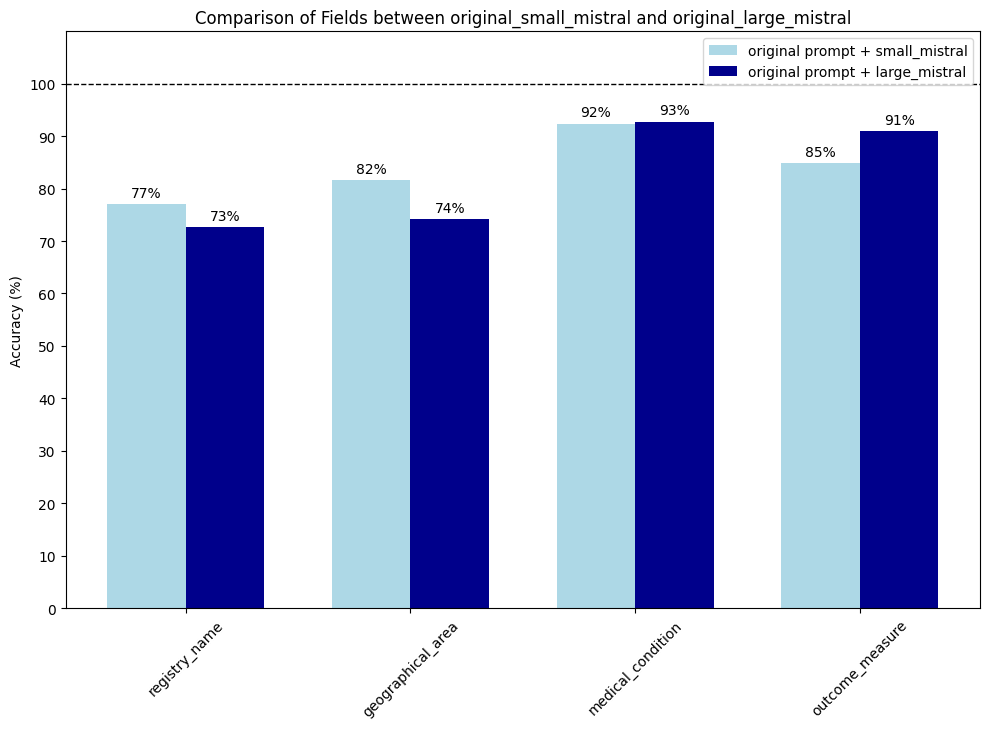

In [31]:
# original + small_mistral  vs original + large_mistral
compare_fields_between_combinations(results_df, "original_small_mistral", "original_large_mistral")

### Compare original x LARGE vs new x LARGE

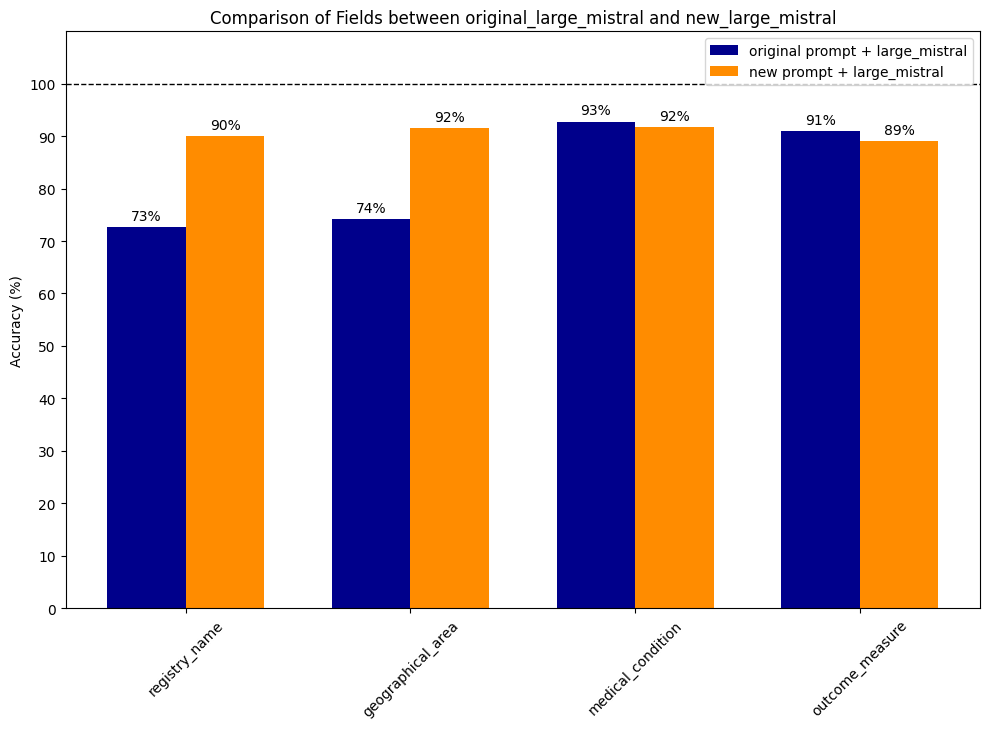

In [32]:
# Compare original x LARGE vs new x LARGE
compare_fields_between_combinations(results_df, "original_large_mistral", "new_large_mistral")

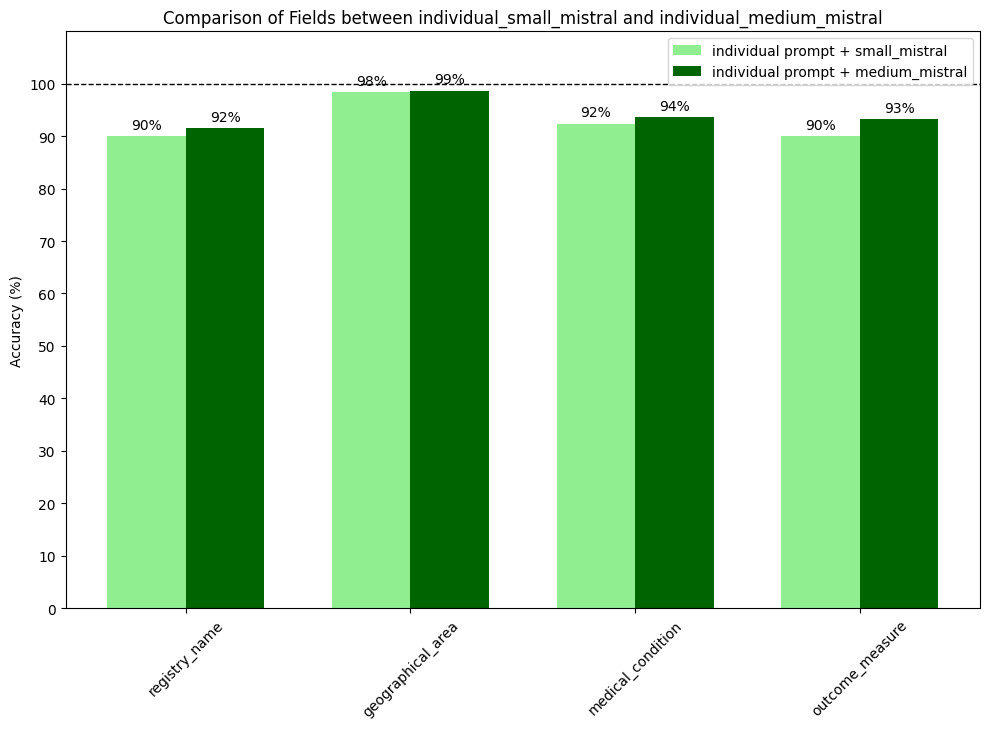

In [33]:
# compare individual x SMALL vs individual x MEDIUM
compare_fields_between_combinations(results_df, "individual_small_mistral", "individual_medium_mistral")

### Official improvement plot: 
1. Compare (RAW original x small mistral) vs 
2. (NEW registry related x original x small mistral) vs 
3. (NEW registry related x INDIVIDUAL x small mistral)

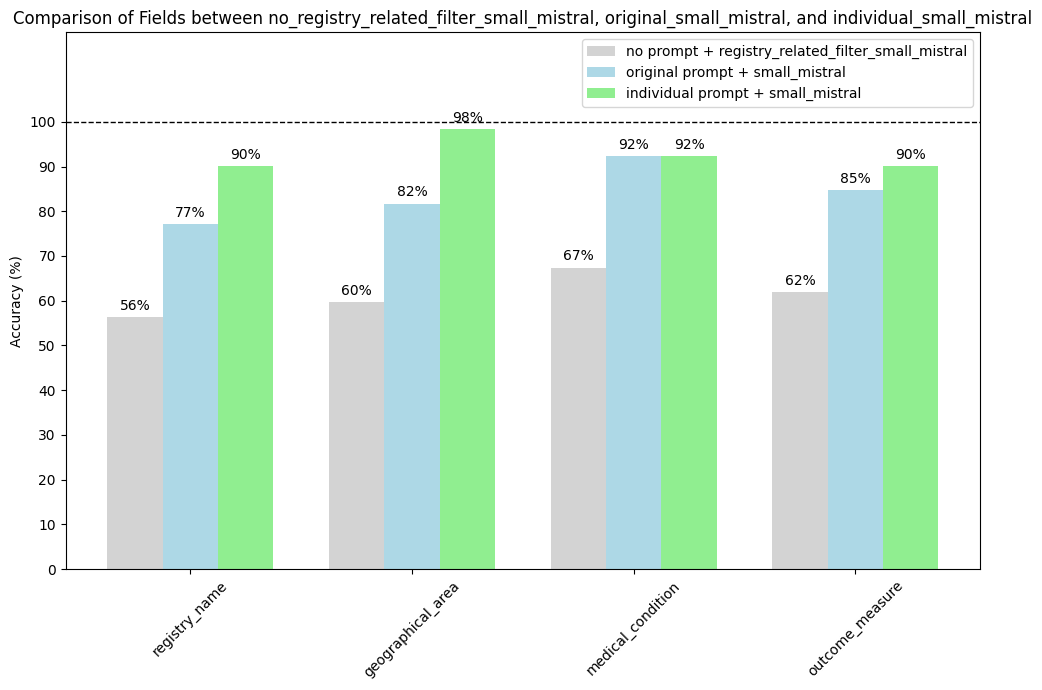

In [49]:
# compare original + large_mistral vs new + large_mistral vs individual + medium_mistral
compare_fields_between_three_combinations(
    results_df, 
    "no_registry_related_filter_small_mistral",
    "original_small_mistral", 
    "individual_small_mistral"
)

### Assess progress of our methods & prompts
1. Original + small_mistral
2. Original + large_mistral
3. New + large_mistral
4. Individual + small_mistral

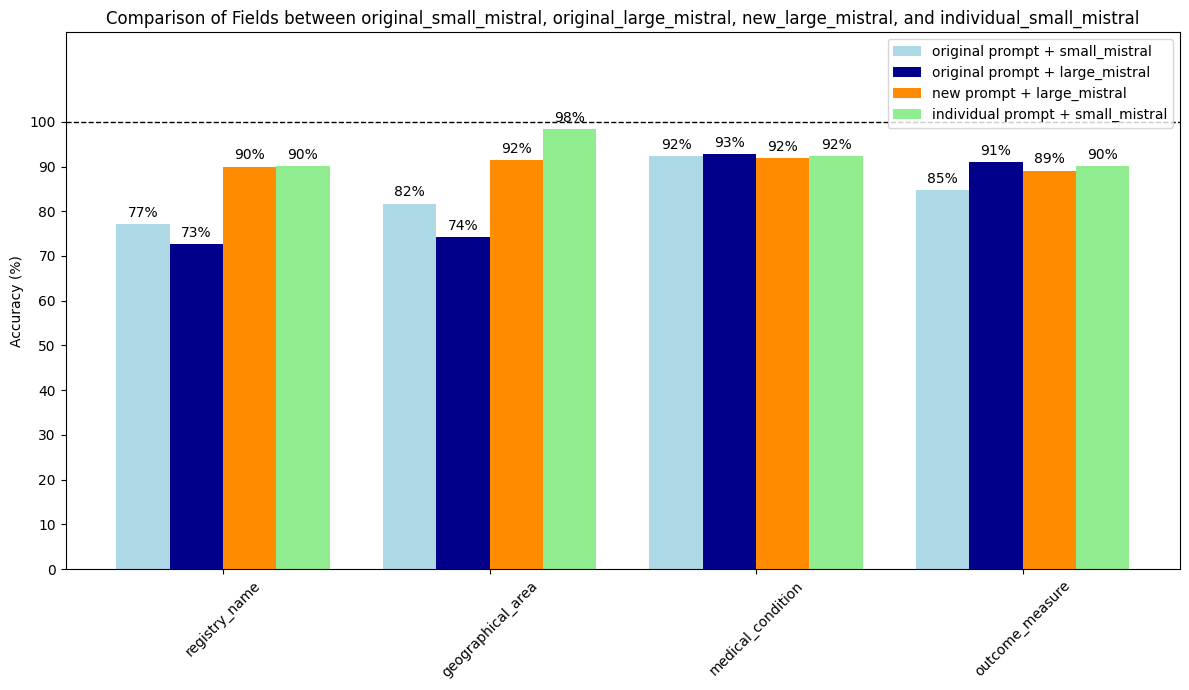

In [37]:
# compare original + small_mistral vs original + large_mistral vs new + large_mistral vs individual + medium_mistral
compare_fields_between_four_combinations(
    results_df, 
    "original_small_mistral", 
    "original_large_mistral", 
    "new_large_mistral", 
    "individual_small_mistral"
)

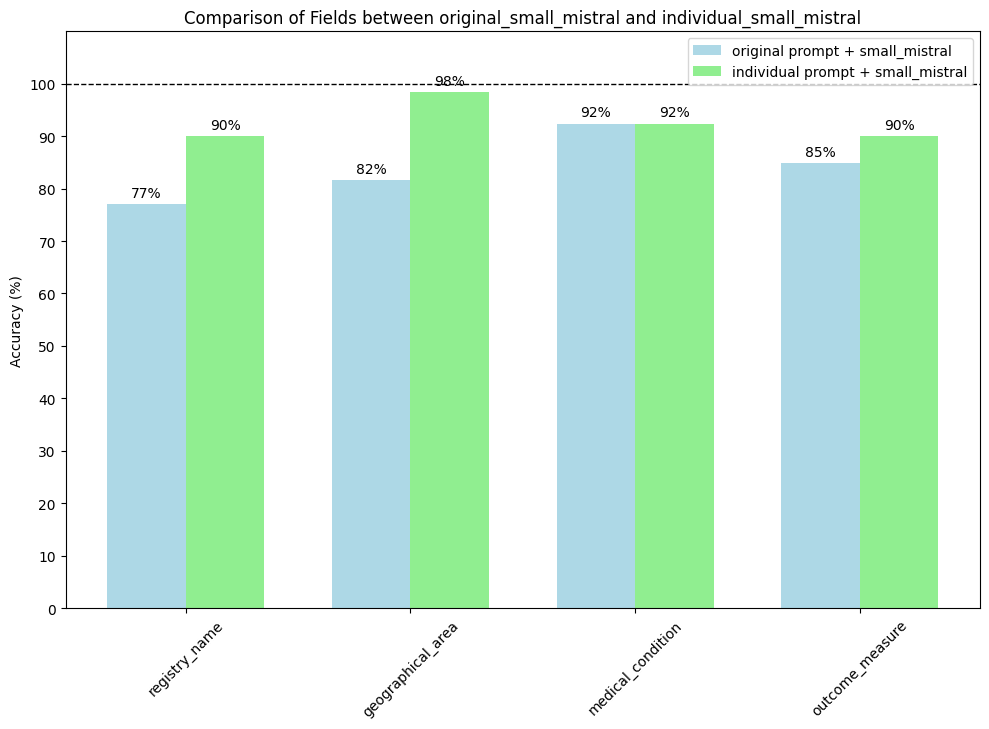

In [38]:
# compare original + small_mistral vs individual + small_mistral (only 2)
compare_fields_between_combinations(
    results_df, 
    "original_small_mistral", 
    "individual_small_mistral"
)

## Calculating Cost Information

In [69]:
# Function to estimate costs from records.jsonl files
def estimate_cost_from_records(records_jsonl_path, model_name):
    """Estimate costs from a JSONL records file.
    
    Args:
        records_jsonl_path: Path to the JSONL records file
        model_name: Name of the model used
        
    Returns:
        Dictionary with cost information
    """
    # Map the model name to the costs_estimation model name
    if "small" in model_name.lower():
        model = "mistral-small-latest"
    elif "medium" in model_name.lower():
        model = "mistral-medium-latest"
    elif "large" in model_name.lower():
        model = "mistral-large-latest"
    else:
        model = "mistral-large-latest"  # Default to large if unknown

    # Load the records
    prompts_list = []
    outputs_list = []
    try:
        with open(records_jsonl_path, "r", encoding="utf-8") as f:
            for line in f:
                record = json.loads(line)
                prompts_list.append(record["prompt"])

                # Handle different response formats from different models
                if "choices" in record["llm_response"]:
                    content = record["llm_response"]["choices"][0]["message"]["content"]
                    outputs_list.append(content)
                elif (isinstance(record["llm_response"], dict) and "content" in record["llm_response"]):
                    outputs_list.append(record["llm_response"]["content"])
                else:
                    # Default for other formats
                    outputs_list.append(str(record["llm_response"]))

        # Estimate costs
        result = costs_estimation.estimate(
            prompts=prompts_list, generations=outputs_list, model=model
        )

        # Return the total cost and the number of records
        return {
            "total_cost": result["total_cost"],
            "num_records": len(prompts_list),
            "cost_details": result,
        }
    except Exception as e:
        print(f"Error processing {records_jsonl_path}: {e}")
        return {
            "total_cost": 0,
            "num_records": 0,
            "cost_details": {},
        }

In [72]:
# Function to calculate costs for each combination
def calculate_costs(prompt_version, model, fields):
    """Calculate costs for a specific combination of prompt version and model.
    
    Args:
        prompt_version: 'original', 'new', or 'individual'
        model: 'small_mistral', 'medium_mistral', or 'large_mistral'
        fields: List of fields to process
        
    Returns:
        Dictionary with cost information
    """
    costs = {}
    total_test_cost = 0
    
    if prompt_version in ['original', 'new']:
        # For original and new prompt versions, load the single records file
        records_path = f"data/W02/{prompt_version}/R21_extract_metadata/{model}/records.jsonl"
        cost_data = estimate_cost_from_records(records_path, model)
        total_test_cost = cost_data['total_cost']
        
        # Cost is the same for all fields
        for field in fields:
            costs[field] = {
                # Accuracy and total_samples are loaded separately
                "cost_test_records": None  # No per-field cost for original/new
            }
    else:  # individual
        # For individual prompt version, load a separate records file for each field
        for field in fields:
            records_path = f"data/W03/R31_extract_metadata_one_by_one/{field}/{model}/{field}_records.jsonl"
            cost_data = estimate_cost_from_records(records_path, model)
            field_cost = cost_data['total_cost']
            total_test_cost += field_cost
            
            costs[field] = {
                # Accuracy and total_samples are loaded separately
                "cost_test_records": field_cost
            }
    
    # Calculate total cost on entire registry-related publications
    # total_test_cost/230*0.92*220k / 2 (batch inference)
    total_cost = (total_test_cost / 230) * 0.92 * 220000 / 2
    
    return {
        "total_test_cost": total_test_cost,
        "total_cost": total_cost,
        "field_costs": costs
    }

In [73]:
# Calculate costs for each combination
cost_results = {}
for combo in combinations:
    prompt_version = combo["prompt_version"]
    model = combo["model"]
    key = f"{prompt_version}_{model}"
    
    print(f"Calculating costs for {prompt_version} × {model}...")
    cost_data = calculate_costs(prompt_version, model, FIELDS_LIST)
    cost_results[key] = cost_data
    print(f"  Total test cost: €{cost_data['total_test_cost']:.4f}")
    print(f"  Estimated total cost for all publications: €{cost_data['total_cost']:.2f}")
    
    # Update our comparison results with cost information
    if key in comparison_results:
        comparison_results[key]["total_test_cost"] = cost_data["total_test_cost"]
        comparison_results[key]["total_cost"] = cost_data["total_cost"]
        
        # Add field-specific costs for individual prompt version
        for field in FIELDS_LIST:
            if field in comparison_results[key] and field in cost_data["field_costs"]:
                comparison_results[key][field].update(cost_data["field_costs"][field])

Calculating costs for original × small_mistral...
Estimating costs for model: mistral-small-latest
  Total test cost: €0.0728
  Estimated total cost for all publications: €32.02
Calculating costs for original × large_mistral...
Estimating costs for model: mistral-large-latest
  Total test cost: €0.0728
  Estimated total cost for all publications: €32.02
Calculating costs for original × large_mistral...
Estimating costs for model: mistral-large-latest
  Total test cost: €1.3128
  Estimated total cost for all publications: €577.63
Calculating costs for new × small_mistral...
Estimating costs for model: mistral-small-latest
  Total test cost: €1.3128
  Estimated total cost for all publications: €577.63
Calculating costs for new × small_mistral...
Estimating costs for model: mistral-small-latest
  Total test cost: €0.1587
  Estimated total cost for all publications: €69.85
Calculating costs for new × large_mistral...
Estimating costs for model: mistral-large-latest
  Total test cost: €0.15

## Cost Analysis Summary

In [ ]:
# Calculate average cost-effectiveness by prompt version
avg_cost_effectiveness = cost_df.groupby(['prompt_version'])['accuracy_per_euro'].mean().reset_index()
print("Average accuracy per euro by prompt version:")
for _, row in avg_cost_effectiveness.iterrows():
    print(f"{row['prompt_version']}: {row['accuracy_per_euro']:.2f}% per euro")

print("\nAverage accuracy per euro by model:")
avg_by_model = cost_df.groupby(['model'])['accuracy_per_euro'].mean().reset_index()
for _, row in avg_by_model.iterrows():
    print(f"{row['model']}: {row['accuracy_per_euro']:.2f}% per euro")

# Find the most cost-effective combination for each field
print("\nMost cost-effective combination for each field:")
for field in FIELDS_LIST:
    field_data = cost_df[cost_df['field'] == field]
    if not field_data.empty:
        best_row = field_data.loc[field_data['accuracy_per_euro'].idxmax()]
        print(f"{field}: {best_row['prompt_version']} + {best_row['model']} = {best_row['accuracy_per_euro']:.2f}% per euro")

# Find the best combination in terms of absolute accuracy vs. cost ratio
print("\nOverall most cost-effective combinations:")
cost_df_sorted = cost_df.sort_values(by='accuracy_per_euro', ascending=False)
for i, row in cost_df_sorted.head(5).iterrows():
    print(f"{row['prompt_version']} + {row['model']} for {row['field']}: {row['accuracy']:.2f}% accuracy at €{row['cost']:.4f} = {row['accuracy_per_euro']:.2f}% per euro")

## Export Final Comparison Results

In [ ]:
# Export the detailed comparison results to JSON for future reference
with open('comparison_results_with_costs.json', 'w') as f:
    # Convert the dictionary to a serializable format
    serializable_results = {}
    for key, value in comparison_results.items():
        serializable_results[key] = {}
        for k, v in value.items():
            if isinstance(v, dict):
                serializable_results[key][k] = v
            elif isinstance(v, np.ndarray):
                serializable_results[key][k] = v.tolist()
            else:
                serializable_results[key][k] = v
    
    json.dump(serializable_results, f, indent=2)

print("Exported comparison results with costs to comparison_results_with_costs.json")

## Key Cost Insights

After analyzing the costs across different combinations of prompt versions and models, we can draw several key insights:

1. **Cost-effectiveness trade-offs**: While larger models tend to achieve higher accuracy, they also come with significantly higher costs. The small_mistral model offers better cost-effectiveness for most fields.

2. **Prompt version impact**: Individual prompts can be more expensive in total but may be more cost-effective for specific fields, especially when precision is critical.

3. **Field-specific considerations**: 
   - For fields like geographical_area, even simple models with basic prompts achieve high accuracy at low cost
   - For challenging fields like registry_name, investing in more sophisticated approaches may be justified

4. **Scaling implications**: When considering the full dataset of 220K registry-related publications, the cost differences between approaches become substantial, suggesting that optimizing for cost-effectiveness is important for large-scale deployments.

5. **Hybrid approach potential**: A hybrid approach could be optimal - using simpler models and prompts for straightforward fields, and more advanced combinations for challenging extractions.

These findings can help guide the selection of the most appropriate prompt and model combinations based on budget constraints and accuracy requirements.

# Extra stats v2

## Extra Stats: Non-Missing Values Comparison

In this section, we'll compare the percentage of non-missing values (values that are not "Not specified" or "Not found") across different combinations of prompt versions and models. This section is independent and can be run without relying on previous sections.

In [39]:
# Import required libraries for this section
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define a dictionary for field name mapping
DICT_FIELD_NAMES = {
    "registry_name": "Registry name",
    "geographical_area": "Geographical area",
    "medical_condition": "Medical condition",
    "outcome_measure": "Outcome measure"
}

# Set working directory
working_dir = "/home/gpinon/more_europa/clean_rdc_experiments/projects/P03_evaluate_extractions/"
os.chdir(working_dir)

# Define fields list
FIELDS_LIST = [
    "registry_name",
    "geographical_area",
    "medical_condition",
    "outcome_measure",
]

# Load evaluation datasets
medical_condition_eval_dataset = pd.read_json(
    "../../datasets/005_evaluate_extraction_process_datasets/medical_condition/final_eval_dataset.json"
)
outcome_measure_eval_dataset = pd.read_json(
    "../../datasets/005_evaluate_extraction_process_datasets/outcome_measure/final_eval_dataset.json"
)
geographical_area_eval_dataset = pd.read_json(
    "../../datasets/005_evaluate_extraction_process_datasets/geographical_area/final_eval_dataset.json"
)
registry_name_eval_dataset = pd.read_json(
    "../../datasets/005_evaluate_extraction_process_datasets/registry_name/final_eval_dataset.json"
)

# Load original metadata extractions (small_mistral)
original_metadata_extractions_small = pd.read_json(
    "data/W02/original/R21_extract_metadata/small_mistral/metadata_extractions.json"
)

# Load new metadata extractions (large_mistral)
new_metadata_extractions = pd.read_json(
    "data/W02/new/R21_extract_metadata/large_mistral/metadata_extractions.json"
)

# Load individual extractions (small_mistral)
individual_extractions_small = {}
for field in FIELDS_LIST:
    individual_extractions_small[field] = pd.read_json(
        f"data/W03/R31_extract_metadata_one_by_one/{field}/small_mistral/{field}_metadata_extractions.json"
    )

In [40]:
# Define the combinations we want to analyze
comparison_combinations = [
    {"name": "Evaluation", "color": "#1f77b4"},  # Blue
    {"name": "Original + Small Mistral", "color": "#ff7f0e"},  # Orange
    {"name": "New + Large Mistral", "color": "#2ca02c"},  # Green
    {"name": "Individual + Small Mistral", "color": "#d62728"},  # Red
    {"name": "Individual + Small Mistral (Official)", "color": "#E0FFE0", "special": True}  # Light green
]

In [41]:
# Define helper functions for computing metrics

# Function to compute split of correct field values in evaluation datasets
def compute_split_correct_field(eval_dataset, field_name):
    """Computes the split of the correct field values in the evaluation dataset."""
    total = len(eval_dataset)
    not_specified = eval_dataset[field_name].value_counts().get("Not specified", 0)
    not_found = eval_dataset[field_name].value_counts().get("Not found", 0)
    missing = not_specified + not_found
    correct_values = total - missing
    
    return {
        "total": total,
        "missing": missing,
        "correct_values": correct_values
    }

# Function to compute split of field values in LLM responses
def compute_split_llm_response_field(metadata_extractions, field_name):
    """Computes the split of the field values in the LLM response."""
    total = len(metadata_extractions)
    # Use the dictionary to get formatted field name
    field_formatted = DICT_FIELD_NAMES.get(field_name)
    llm_response_field = metadata_extractions['llm_response'].apply(lambda x: x.get(field_formatted, "Not specified"))
    not_specified = llm_response_field.value_counts().get("Not specified", 0)
    not_found = llm_response_field.value_counts().get("Not found", 0)
    missing = not_specified + not_found
    specified_values = total - missing
    
    return {
        "total": total,
        "missing": missing,
        "specified_values": specified_values
    }

# Function to compute stats for extra fields
def compute_extra_fields_stats(extractions, field_name):
    """Computes the stats for extra fields in the metadata extractions."""
    total = len(extractions)
    # Use the dictionary to get formatted field name
    field_formatted = DICT_FIELD_NAMES.get(field_name)
    llm_response_field = extractions['llm_response'].apply(lambda x: x.get(field_formatted, "Missing field"))
    value_counts = llm_response_field.value_counts()
    
    return {
        "total": total,
        "value_counts": value_counts
    }

# Function to compute non-missing percentage
def compute_non_missing_percentage(data, field):
    """Calculate percentage of non-missing values for a field."""
    # Use the dictionary to get formatted field name
    field_formatted = DICT_FIELD_NAMES.get(field)
    total = len(data)
    missing = 0
    
    for _, row in data.iterrows():
        value = row.get(field_formatted, None)
        if value is None and 'llm_response' in row:
            value = row['llm_response'].get(field_formatted, "Not specified")
        if value in ["Not specified", "Not found"]:
            missing += 1
    
    non_missing = total - missing
    return (non_missing / total) * 100 if total else 0

# Function to compute percentage of registry names marked as Official/Unique
def compute_official_registry_percentage(data):
    """Calculate percentage of registry names marked as Official/Unique."""
    total = len(data)
    official_count = 0
    
    for _, row in data.iterrows():
        if 'llm_response' in row and "Registry name is Official/Unique" in row['llm_response']:
            if row['llm_response']["Registry name is Official/Unique"] == "Yes":
                official_count += 1
    
    return (official_count / total) * 100 if total else 0

In [42]:
# Create a mapping of evaluation datasets
eval_datasets = {
    "medical_condition": medical_condition_eval_dataset,
    "outcome_measure": outcome_measure_eval_dataset,
    "geographical_area": geographical_area_eval_dataset,
    "registry_name": registry_name_eval_dataset
}

# Verify dataset availability
print("Checking dataset availability:")
print(f"Original + Small Mistral: {len(original_metadata_extractions_small)} records")
print(f"New + Large Mistral: {len(new_metadata_extractions)} records")
for field in FIELDS_LIST:
    if field in individual_extractions_small:
        print(f"Individual + Small Mistral ({field}): {len(individual_extractions_small[field])} records")
    else:
        print(f"Individual + Small Mistral ({field}): Not available")

print("\nEvaluation datasets:")
for field, dataset in eval_datasets.items():
    print(f"{field}: {len(dataset)} records")

Checking dataset availability:
Original + Small Mistral: 233 records
New + Large Mistral: 233 records
Individual + Small Mistral (registry_name): 233 records
Individual + Small Mistral (geographical_area): 200 records
Individual + Small Mistral (medical_condition): 233 records
Individual + Small Mistral (outcome_measure): 233 records

Evaluation datasets:
medical_condition: 260 records
outcome_measure: 260 records
geographical_area: 232 records
registry_name: 223 records


In [43]:
# Function to collect non-missing percentages from all sources
def collect_non_missing_percentages():
    """Collect percentages of non-missing values from different sources."""
    results = []
    
    # 1. Evaluation datasets (ground truth)
    for field in FIELDS_LIST:
        field_formatted = DICT_FIELD_NAMES.get(field)
        eval_dataset = eval_datasets.get(field)
        if eval_dataset is not None:
            eval_col = f"correct_{field}"
            split_eval = compute_split_correct_field(eval_dataset, eval_col)
            pct_eval = (split_eval['correct_values'] / split_eval['total']) * 100 if split_eval['total'] else 0
            results.append({
                "field": field,
                "field_formatted": field_formatted,
                "source": "Evaluation",
                "percentage": pct_eval,
                "special": False
            })
    
    # 2. Original prompt + small_mistral
    for field in FIELDS_LIST:
        field_formatted = DICT_FIELD_NAMES.get(field)
        split_orig = compute_split_llm_response_field(original_metadata_extractions_small, field)
        pct_orig = (split_orig['specified_values'] / split_orig['total']) * 100 if split_orig['total'] else 0
        results.append({
            "field": field,
            "field_formatted": field_formatted,
            "source": "Original + Small Mistral",
            "percentage": pct_orig,
            "special": False
        })
    
    # 3. New prompt + large_mistral
    for field in FIELDS_LIST:
        field_formatted = DICT_FIELD_NAMES.get(field)
        split_new = compute_split_llm_response_field(new_metadata_extractions, field)
        pct_new = (split_new['specified_values'] / split_new['total']) * 100 if split_new['total'] else 0
        results.append({
            "field": field,
            "field_formatted": field_formatted,
            "source": "New + Large Mistral",
            "percentage": pct_new,
            "special": False
        })
    
    # 4. Individual prompt + small_mistral
    for field in FIELDS_LIST:
        if field in individual_extractions_small:
            field_formatted = DICT_FIELD_NAMES.get(field)
            pct_indiv = compute_non_missing_percentage(individual_extractions_small[field], field)
            results.append({
                "field": field,
                "field_formatted": field_formatted,
                "source": "Individual + Small Mistral",
                "percentage": pct_indiv,
                "special": False
            })
            
            # Special case for registry_name: add "Official/Unique" percentage
            if field == "registry_name":
                pct_official = compute_official_registry_percentage(individual_extractions_small[field])
                results.append({
                    "field": field,
                    "field_formatted": field_formatted,
                    "source": "Individual + Small Mistral (Official)",
                    "percentage": pct_official,
                    "special": True
                })
    
    return pd.DataFrame(results)

In [44]:
# Collect and display the non-missing percentages
missing_stats_df = collect_non_missing_percentages()
missing_stats_df

,field,field_formatted,source,percentage,special
0,registry_name,Registry name,Evaluation,98.206278,False
1,geographical_area,Geographical area,Evaluation,81.465517,False
2,medical_condition,Medical condition,Evaluation,95.769231,False
3,outcome_measure,Outcome measure,Evaluation,97.307692,False
4,registry_name,Registry name,Original + Small Mistral,78.111588,False
5,geographical_area,Geographical area,Original + Small Mistral,62.231760,False
6,medical_condition,Medical condition,Original + Small Mistral,95.708155,False
7,outcome_measure,Outcome measure,Original + Small Mistral,98.283262,False
8,registry_name,Registry name,New + Large Mistral,99.570815,False
9,geographical_area,Geographical area,New + Large Mistral,87.982833,False


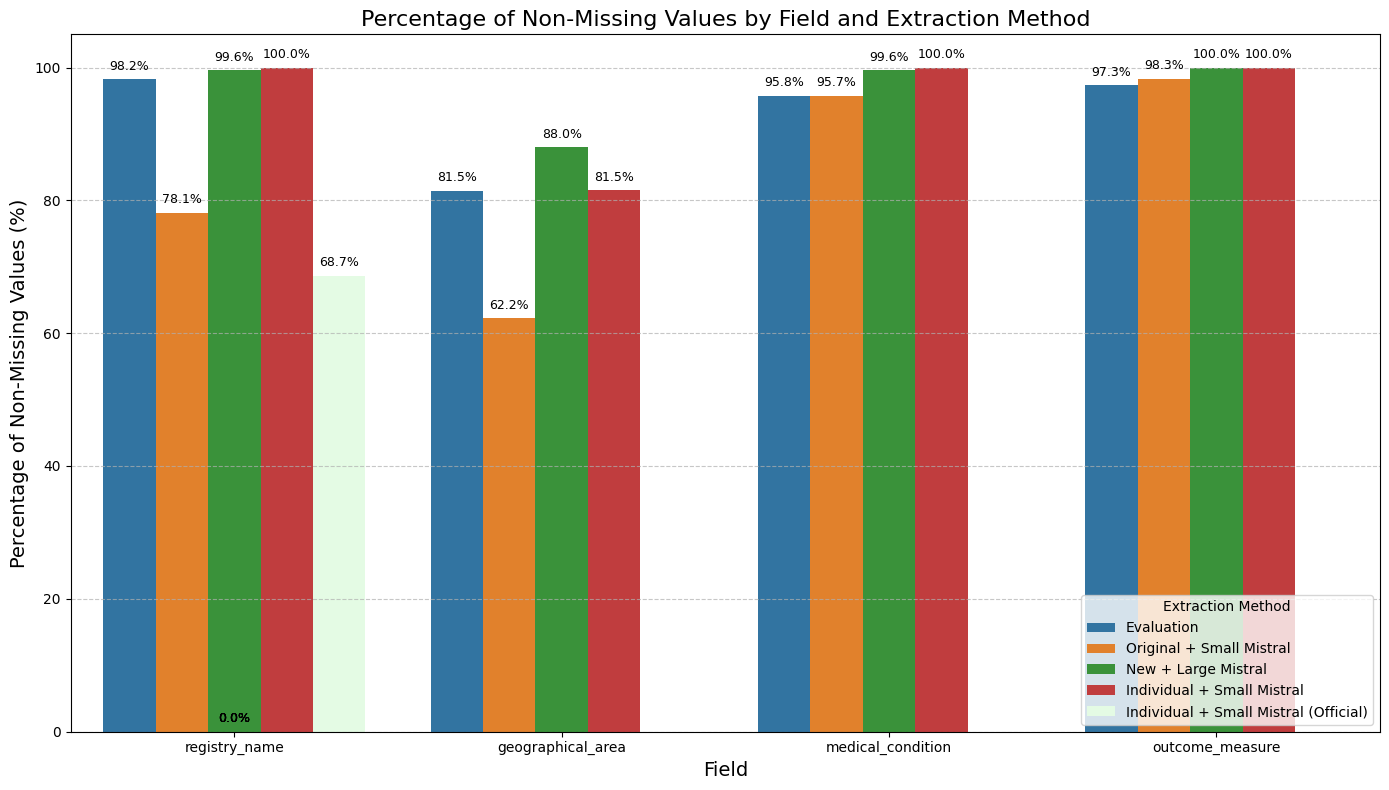

In [45]:
# Create a bar chart comparing non-missing percentages
plt.figure(figsize=(14, 8))

# Define a color palette based on our predefined combinations
color_palette = {combo['name']: combo['color'] for combo in comparison_combinations}

# Create the grouped bar chart
chart = sns.barplot(
    x="field", 
    y="percentage", 
    hue="source", 
    data=missing_stats_df, 
    palette=color_palette,
    errorbar=None
)

# Add percentage values on top of bars
for i, bar in enumerate(chart.patches):
    height = bar.get_height()
    chart.text(
        bar.get_x() + bar.get_width()/2.,
        height + 1,
        f"{height:.1f}%",
        ha="center", 
        va="bottom", 
        rotation=0,
        fontsize=9
    )

# Set chart title and labels
plt.title("Percentage of Non-Missing Values by Field and Extraction Method", fontsize=16)
plt.xlabel("Field", fontsize=14)
plt.ylabel("Percentage of Non-Missing Values (%)", fontsize=14)
plt.ylim(0, 105)  # Make room for percentage labels
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=0)
plt.legend(title="Extraction Method")
plt.tight_layout()
plt.show()

### Analysis of Non-Missing Values

In [24]:
# Analyze the results
# Calculate average percentage of non-missing values by source
avg_by_source = missing_stats_df[~missing_stats_df['special']].groupby('source')['percentage'].mean().reset_index()

print("Average percentage of non-missing values by extraction method:")
for _, row in avg_by_source.iterrows():
    print(f"{row['source']}: {row['percentage']:.1f}%")

# Find the best method for each field
print("\nBest extraction method for non-missing values by field:")
for field in FIELDS_LIST:
    field_data = missing_stats_df[(missing_stats_df['field'] == field) & (~missing_stats_df['special'])]
    if not field_data.empty():
        best_row = field_data.loc[field_data['percentage'].idxmax()]
        print(f"{field}: {best_row['source']} = {best_row['percentage']:.1f}%")

# Special analysis for registry_name official status
registry_official = missing_stats_df[(missing_stats_df['field'] == "registry_name") & (missing_stats_df['special'])]
if not registry_official.empty():
    pct_official = registry_official['percentage'].values[0]
    pct_non_missing = missing_stats_df[(missing_stats_df['field'] == "registry_name") & 
                                      (missing_stats_df['source'] == "Individual + Small Mistral")]['percentage'].values[0]
    
    print(f"\nRegistry Name Special Analysis:")
    print(f"Non-missing registry names: {pct_non_missing:.1f}%")
    print(f"Registry names marked as Official/Unique: {pct_official:.1f}%")
    print(f"Percentage of non-missing registry names that are Official/Unique: {(pct_official/pct_non_missing*100) if pct_non_missing > 0 else 0:.1f}%")

Average percentage of non-missing values by extraction method:
Evaluation: 93.2%
Individual + Small Mistral: 70.4%
New + Large Mistral: 71.9%
Original + Small Mistral: 64.1%

Best extraction method for non-missing values by field:


TypeError: 'bool' object is not callable